<font size=10><br>Training Tour Route Auto-Generation</font>

## Notebook Intro

This model outlines training the LSTM model that generates a prediction of the next best coordinates based on the sequence of previously visited coordiantes. It also outlines the process of finding the closest known zip code and DMA, assigning that on a map visualization, and continuing the route. 

###  Necesssary Import

In [463]:
import pandas as pd
import io 

# Retrieve scraped data of each national tour and where it stopped
df = pd.read_csv('data/merged_stops_data.csv')

# Set to US only
df['country_code'] = [x[:2] for x in df.full_code]
df = df[df.country_code == 'US']

## Find Coordinates by City for each Tour stop 

In [2]:
import numpy as np
import pandas as pd
import geopy
from geopy.geocoders import Nominatim

In [3]:
def getLocationByGeo(cityname):
     try:
        geolocator = Nominatim(user_agent='nickwilders')
        location = geolocator.geocode(cityname)
        lat = location.latitude
        lng = location.longitude
        return (lat,lng)
     except:
        # except unrecoginisable address
        pass

In [4]:
cities = df.city.unique()
coordinate_list = []

for city in cities:
  coordinates = getLocationByGeo(city)
  coordinate_list.append(coordinates)

In [6]:
# zip together list of cities and coordinates

cities_to_coordinates = list(zip(cities, coordinate_list))
cities_to_coordinates_df = pd.DataFrame(cities_to_coordinates)
cities_to_coordinates_df.columns = ['city', 'coordinates']

In [9]:
# Create dataframe including coordinates for each city on the tour route

df2 = pd.merge(df, cities_to_coordinates_df, on='city', how='inner')

In [18]:
# Reformat to transform to coordinate format

df2.coordinates = list(df2.coordinates)
df2.coordinates = [list(x) for x in df2.coordinates]

In [19]:
# Create coordinate list and split up coordinates into latitude and longitude features 

coordinate_list = df2.coordinates

df2['coordinates'] = [tuple(x) for x in coordinate_list]

df2['latitude'] = [x[0] for x in df2.coordinates]
df2['longitude'] = [x[1] for x in df2.coordinates]

## Simple StatsModel Time Series

<br><b>This was designed as a baseline model for understanding how the data could potentially be predicted</b><br><br>

In [369]:
# Set Testing sample from one of the Wicked National Tours

test_df = df2[df2.tour_descript == 'wicked (tour: emerald city)'].sort_values(by='city_opening_date')[['tour_descript', 'latitude', 'longitude']].reset_index()


In [370]:
# Set train and validation sets

train = test_df[:int(0.6*(len(test_df)))][['latitude', 'longitude']]
valid = test_df[int(0.6*(len(test_df))):][['latitude', 'longitude']]

In [371]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

In [372]:
# Predict values, and list

prediction = model_fit.forecast(model_fit.y, steps=len(valid))
prediction[:5]

array([[ 37.12391887, -84.56140452],
       [ 36.61545122, -86.3539815 ],
       [ 36.34650741, -87.45343295],
       [ 36.18646884, -88.11280074],
       [ 36.09063335, -88.50780253]])

## Keras LSTM Forecasting

<b>These resources were essential to understanding and properly coding this portion of the Notebook.

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://www.kaggle.com/pablocastilla/predict-earthquakes-with-lstm

In [373]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
test_df[['scaled_latitude', 'scaled_longitude']] = scaler.fit_transform(test_df[['latitude', 'longitude']])

In [374]:
train = test_df[:int(0.8*(len(test_df)))][['latitude', 'longitude']].to_numpy()
test = test_df[int(0.8*(len(test_df))):][['latitude', 'longitude']].to_numpy()

train_X, long_train_y, lat_train_y = train[:, :], train[:, -1], train[:, 0]
test_X, long_test_y, lat_test_y = test[:, :], test[:, -1], test[:, 0]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, long_train_y.shape, lat_train_y.shape, test_X.shape, long_test_y.shape, lat_test_y.shape)

(91, 1, 2) (91,) (91,) (23, 1, 2) (23,) (23,)


## Longitude LSTM Model (first round of training)

<br><b>This RNN has three hidden layers - a dropout layer given the relatively small amount of data, and two dense layers with two and five neurons, respectively. These numbers were tuned and optimized over several training rounds. 

In [375]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

# design network
long_model = Sequential()
# Add LSTM model 
long_model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))

long_model.add(Dropout(0.05))

# Add processing layer for longitude and latitude
long_model.add(Dense(2))

# Add further processing layer to create US boundaries and movement patterns
long_model.add(Dense(5))

long_model.compile(loss='mae', optimizer='adam')


In [376]:
# fit network
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
long_history = long_model.fit(train_X, long_train_y, epochs=500, batch_size=10, 
                              validation_data=(test_X, long_test_y), verbose=2, shuffle=False, callbacks=[es])


Epoch 1/500
10/10 - 1s - loss: 91.3261 - val_loss: 97.0602
Epoch 2/500
10/10 - 0s - loss: 90.5475 - val_loss: 96.1543
Epoch 3/500
10/10 - 0s - loss: 89.5593 - val_loss: 94.9744
Epoch 4/500
10/10 - 0s - loss: 88.2772 - val_loss: 93.5180
Epoch 5/500
10/10 - 0s - loss: 86.7463 - val_loss: 91.8507
Epoch 6/500
10/10 - 0s - loss: 85.0245 - val_loss: 90.1330
Epoch 7/500
10/10 - 0s - loss: 83.2899 - val_loss: 88.2964
Epoch 8/500
10/10 - 0s - loss: 81.3883 - val_loss: 86.2560
Epoch 9/500
10/10 - 0s - loss: 79.2435 - val_loss: 83.9511
Epoch 10/500
10/10 - 0s - loss: 76.8580 - val_loss: 81.3458
Epoch 11/500
10/10 - 0s - loss: 74.0158 - val_loss: 78.3339
Epoch 12/500
10/10 - 0s - loss: 70.8978 - val_loss: 75.0214
Epoch 13/500
10/10 - 0s - loss: 67.4961 - val_loss: 71.3748
Epoch 14/500
10/10 - 0s - loss: 63.6647 - val_loss: 67.4685
Epoch 15/500
10/10 - 0s - loss: 59.6616 - val_loss: 63.3652
Epoch 16/500
10/10 - 0s - loss: 55.5251 - val_loss: 59.0700
Epoch 17/500
10/10 - 0s - loss: 51.2605 - val_los

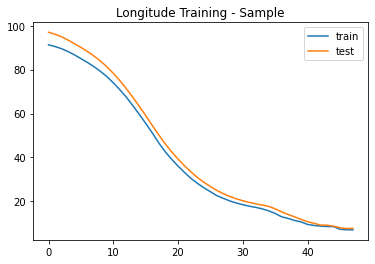

In [377]:
import matplotlib.pyplot as plt
# plot history

#fig,ax = plt.subplots(figsize=(10,10))

plt.plot(long_history.history['loss'], label='train')
plt.plot(long_history.history['val_loss'], label='test')
plt.title('Longitude Training - Sample')
plt.legend()
plt.show()

## Latitude LSTM Model (first round of training)

<b><br>This is a less complex network, with only one layer (with four neuron), because latitude has fewer options and has been easier to train. Two layers also made the production model take much longer.</b><br><br>

In [380]:
lat_model = Sequential()
lat_model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
#lat_model.add(Dense(2))
lat_model.add(Dense(4))
lat_model.compile(loss='mae', optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
lat_history = lat_model.fit(train_X, lat_train_y, epochs=300, batch_size=15, validation_data=(test_X, lat_test_y), verbose=2, shuffle=False, callbacks=[es])


Epoch 1/300
7/7 - 0s - loss: 35.6373 - val_loss: 37.6104
Epoch 2/300
7/7 - 0s - loss: 34.5554 - val_loss: 36.5057
Epoch 3/300
7/7 - 0s - loss: 33.4300 - val_loss: 35.2966
Epoch 4/300
7/7 - 0s - loss: 32.1529 - val_loss: 33.8321
Epoch 5/300
7/7 - 0s - loss: 30.5705 - val_loss: 31.9781
Epoch 6/300
7/7 - 0s - loss: 28.6812 - val_loss: 29.8552
Epoch 7/300
7/7 - 0s - loss: 26.7102 - val_loss: 27.6826
Epoch 8/300
7/7 - 0s - loss: 24.7493 - val_loss: 25.6144
Epoch 9/300
7/7 - 0s - loss: 22.9093 - val_loss: 23.6956
Epoch 10/300
7/7 - 0s - loss: 21.1769 - val_loss: 21.8576
Epoch 11/300
7/7 - 0s - loss: 19.4870 - val_loss: 20.0383
Epoch 12/300
7/7 - 0s - loss: 17.7968 - val_loss: 18.2224
Epoch 13/300
7/7 - 0s - loss: 16.1055 - val_loss: 16.4240
Epoch 14/300
7/7 - 0s - loss: 14.4267 - val_loss: 14.6393
Epoch 15/300
7/7 - 0s - loss: 12.7085 - val_loss: 12.7819
Epoch 16/300
7/7 - 0s - loss: 10.9567 - val_loss: 10.9286
Epoch 17/300
7/7 - 0s - loss: 9.3538 - val_loss: 9.1233
Epoch 18/300
7/7 - 0s - l

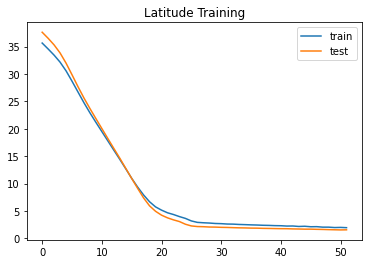

In [381]:
import matplotlib.pyplot as plt

plt.plot(lat_history.history['loss'], label='train')
plt.plot(lat_history.history['val_loss'], label='test')
plt.title('Latitude Training')
plt.legend()
plt.show()

## Train /Evaluate More Tour Routes

In [345]:
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

def model_RMSE(model, test_y): 
    # make a prediction
    yhat = model.predict(test_X)
    test_X_shaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X_shaped[:, 1:]), axis=1)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y_shaped = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y_shaped, test_X_shaped[:, 1:]), axis=1)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return 'Test RMSE: %.3f' % rmse

In [346]:
long = model_RMSE(long_model, long_test_y)
lat = model_RMSE(lat_model, lat_test_y)

In [347]:
print('Longitude', str(long), '    Latitude', str(lat))

Longitude Test RMSE: 20.646     Latitude Test RMSE: 3.062


In [348]:
# Filter out standing shows or shows that never opened

df2 = df2[df2.tour_descript!='the last ship (tour)']
df2 = df2[df2.tour_descript!='wicked (tour: san francisco)']
df2 = df2[df2.tour_descript!='wicked (tour: chicago)']
df2 = df2[df2.tour_descript!='wicked (tour: los angeles)']
df2 = df2[df2.tour_descript!='hamilton (tour: eliza)']
df2 = df2[df2.tour_descript!='what the constitution means to me (tour)']

show_list = df2.tour_descript.unique()

### Feature Engineering - Distance from Last Stop

In [283]:
import mpu
def distance(point1, point2):
    return mpu.haversine_distance(point1, point2)

In [284]:
df2.reset_index(inplace=True)

In [285]:
coordinate_list = []

for i, lat in enumerate(df2.latitude):
    coordinates = (lat,df2.longitude[i])
    coordinate_list.append(coordinates)
    

df2['coordinates'] = coordinate_list

In [286]:
test_df

,index,tour_descript,latitude,longitude,coordinates,distance_from_last
0,509,hamilton (tour: and peggy),37.779026,-122.419906,"(37.7790262, -122.4199061)",0.000000
1,636,hamilton (tour: and peggy),45.520247,-122.674195,"(45.5202471, -122.6741949)",861.042418


### Null Feature - Distance from Last

In [50]:
distances_list = []

for i, numbers in enumerate(test_df.coordinates):
    if i == 0:
        dist = 0
    else:
        dist = distance(numbers, test_df.coordinates[i-1])
        
    distances_list.append(dist)

test_df['distance_from_last'] = distances_list

AttributeError: 'DataFrame' object has no attribute 'coordinates'

### Train a Bunch

In [382]:
# Set blank latitude and longitude RMSE lists

lat_RMSE_list = []
long_RMSE_list = []

# Creating show list, list of all possible titles
show_list = df2.groupby('tour_descript').count().sort_values(by='index', ascending=False).index

# Iterate training process of Keras model 
for show in show_list:
    print("\n\n\n" + str(show) + "\n\n\n")
    test_df = df2[df2.tour_descript == show].sort_values(by='city_opening_date')[['tour_descript', 'latitude', 'longitude', 'coordinates']].reset_index()

    distances_list = []
    for i, numbers in enumerate(test_df.coordinates):
        if i == 0:
            dist = 0
        else:
            dist = distance(numbers, test_df.coordinates[i-1])
        distances_list.append(dist)
    test_df['distance_from_last'] = distances_list
    
    train = test_df[:int(0.8*(len(test_df)))][['latitude', 'longitude']].to_numpy()
    test = test_df[int(0.8*(len(test_df))):][['latitude', 'longitude']].to_numpy()

    train_X, long_train_y, lat_train_y = train[:, :], train[:, -1], train[:, 0]
    test_X, long_test_y, lat_test_y = test[:, :], test[:, -1], test[:, 0]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, long_train_y.shape, lat_train_y.shape, test_X.shape, long_test_y.shape, lat_test_y.shape)

    # fit network
    from tensorflow.keras.callbacks import EarlyStopping

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    lat_history = lat_model.fit(train_X, lat_train_y, epochs=200, batch_size=10, validation_data=(test_X, lat_test_y), verbose=2, shuffle=False, callbacks=[es])
    lat = model_RMSE(lat_model, lat_test_y)
    lat_RMSE_list.append(lat[11:])

    long_history = long_model.fit(train_X, long_train_y, epochs=200, batch_size=10, validation_data=(test_X, long_test_y), verbose=2, shuffle=False, callbacks=[es])
    long = model_RMSE(long_model, long_test_y)
    long_RMSE_list.append(long[11:])





jersey boys (tour)



(604, 1, 2) (604,) (604,) (152, 1, 2) (152,) (152,)
Epoch 1/200
61/61 - 0s - loss: 2.5518 - val_loss: 4.7769
Epoch 2/200
61/61 - 0s - loss: 2.5614 - val_loss: 3.2029
Epoch 3/200
61/61 - 0s - loss: 2.2216 - val_loss: 4.2344
Epoch 00003: early stopping
Epoch 1/200
61/61 - 0s - loss: 6.8464 - val_loss: 3.7676
Epoch 2/200
61/61 - 0s - loss: 7.0689 - val_loss: 5.0813
Epoch 00002: early stopping



million dollar quartet (tour)



(152, 1, 2) (152,) (152,) (38, 1, 2) (38,) (38,)
Epoch 1/200
16/16 - 0s - loss: 3.2007 - val_loss: 2.8064
Epoch 2/200
16/16 - 0s - loss: 2.0858 - val_loss: 2.4574
Epoch 3/200
16/16 - 0s - loss: 1.7160 - val_loss: 2.7368
Epoch 00003: early stopping
Epoch 1/200
16/16 - 0s - loss: 7.2395 - val_loss: 7.2878
Epoch 2/200
16/16 - 0s - loss: 5.9199 - val_loss: 6.9360
Epoch 3/200
16/16 - 0s - loss: 5.5311 - val_loss: 7.8962
Epoch 00003: early stopping



the color purple (tour)



(147, 1, 2) (147,) (147,) (37, 1, 2) (37,) (37,)
Epoch 1/200
15/15 - 

5/5 - 0s - loss: 3.4233 - val_loss: 7.6744
Epoch 2/200
5/5 - 0s - loss: 3.8375 - val_loss: 4.9585
Epoch 3/200
5/5 - 0s - loss: 3.2516 - val_loss: 6.8010
Epoch 00003: early stopping



a chorus line (tour)



(44, 1, 2) (44,) (44,) (12, 1, 2) (12,) (12,)
Epoch 1/200
5/5 - 0s - loss: 0.9556 - val_loss: 1.0986
Epoch 2/200
5/5 - 0s - loss: 1.1542 - val_loss: 0.6183
Epoch 3/200
5/5 - 0s - loss: 0.6914 - val_loss: 0.7953
Epoch 00003: early stopping
Epoch 1/200
5/5 - 0s - loss: 3.7349 - val_loss: 2.6856
Epoch 2/200
5/5 - 0s - loss: 3.2211 - val_loss: 2.8166
Epoch 00002: early stopping



the 25th annual putnam county spelling bee (tour)



(44, 1, 2) (44,) (44,) (12, 1, 2) (12,) (12,)
Epoch 1/200
5/5 - 0s - loss: 0.9535 - val_loss: 0.9686
Epoch 2/200
5/5 - 0s - loss: 0.8402 - val_loss: 1.6093
Epoch 00002: early stopping
Epoch 1/200
5/5 - 0s - loss: 3.4060 - val_loss: 4.1196
Epoch 2/200
5/5 - 0s - loss: 3.1879 - val_loss: 4.5393
Epoch 00002: early stopping



avenue q (tour)



(44, 1, 2) (44,

Epoch 2/200
4/4 - 0s - loss: 5.7479 - val_loss: 3.8875
Epoch 3/200
4/4 - 0s - loss: 4.7320 - val_loss: 1.7055
Epoch 4/200
4/4 - 0s - loss: 2.8885 - val_loss: 6.7990
Epoch 00004: early stopping



aladdin (tour)



(30, 1, 2) (30,) (30,) (8, 1, 2) (8,) (8,)
Epoch 1/200
3/3 - 0s - loss: 1.2500 - val_loss: 1.0317
Epoch 2/200
3/3 - 0s - loss: 0.8461 - val_loss: 0.3369
Epoch 3/200
3/3 - 0s - loss: 0.8174 - val_loss: 1.1423
Epoch 00003: early stopping
Epoch 1/200
3/3 - 0s - loss: 3.6694 - val_loss: 1.5183
Epoch 2/200
3/3 - 0s - loss: 3.1010 - val_loss: 3.2945
Epoch 00002: early stopping



south pacific (tour)



(30, 1, 2) (30,) (30,) (8, 1, 2) (8,) (8,)
Epoch 1/200
3/3 - 0s - loss: 1.0576 - val_loss: 0.2493
Epoch 2/200
3/3 - 0s - loss: 0.9861 - val_loss: 0.4208
Epoch 00002: early stopping
Epoch 1/200
3/3 - 0s - loss: 3.2495 - val_loss: 1.3273
Epoch 2/200
3/3 - 0s - loss: 3.7633 - val_loss: 2.4098
Epoch 00002: early stopping



sweet charity (tour)



(29, 1, 2) (29,) (29,) (8, 1, 2) (8,) (

Epoch 3/200
3/3 - 0s - loss: 0.7455 - val_loss: 0.7005
Epoch 4/200
3/3 - 0s - loss: 0.4957 - val_loss: 0.6879
Epoch 5/200
3/3 - 0s - loss: 0.5520 - val_loss: 0.7074
Epoch 00005: early stopping
Epoch 1/200
3/3 - 0s - loss: 2.4480 - val_loss: 3.4423
Epoch 2/200
3/3 - 0s - loss: 3.3566 - val_loss: 3.1528
Epoch 3/200
3/3 - 0s - loss: 2.9117 - val_loss: 3.2929
Epoch 00003: early stopping



come fly away (tour)



(22, 1, 2) (22,) (22,) (6, 1, 2) (6,) (6,)
Epoch 1/200
3/3 - 0s - loss: 0.6710 - val_loss: 0.3192
Epoch 2/200
3/3 - 0s - loss: 0.5461 - val_loss: 0.2637
Epoch 3/200
3/3 - 0s - loss: 0.5797 - val_loss: 0.2836
Epoch 00003: early stopping
Epoch 1/200
3/3 - 0s - loss: 2.5994 - val_loss: 2.9177
Epoch 2/200
3/3 - 0s - loss: 4.0433 - val_loss: 1.3402
Epoch 3/200
3/3 - 0s - loss: 2.7556 - val_loss: 2.3146
Epoch 00003: early stopping



anything goes (tour)



(22, 1, 2) (22,) (22,) (6, 1, 2) (6,) (6,)
Epoch 1/200
3/3 - 0s - loss: 0.3531 - val_loss: 1.7794
Epoch 2/200
3/3 - 0s - loss: 0.40

Epoch 2/200
2/2 - 0s - loss: 1.7481 - val_loss: 2.0883
Epoch 00002: early stopping



sweeney todd (tour)



(15, 1, 2) (15,) (15,) (4, 1, 2) (4,) (4,)
Epoch 1/200
2/2 - 0s - loss: 0.4717 - val_loss: 0.4800
Epoch 2/200
2/2 - 0s - loss: 0.5535 - val_loss: 0.2411
Epoch 3/200
2/2 - 0s - loss: 0.5363 - val_loss: 0.2091
Epoch 4/200
2/2 - 0s - loss: 0.4312 - val_loss: 0.2860
Epoch 00004: early stopping
Epoch 1/200
2/2 - 0s - loss: 2.6679 - val_loss: 2.3831
Epoch 2/200
2/2 - 0s - loss: 2.2083 - val_loss: 1.9749
Epoch 3/200
2/2 - 0s - loss: 2.1188 - val_loss: 2.5669
Epoch 00003: early stopping



into the woods (tour)



(14, 1, 2) (14,) (14,) (4, 1, 2) (4,) (4,)
Epoch 1/200
2/2 - 0s - loss: 0.4202 - val_loss: 0.4431
Epoch 2/200
2/2 - 0s - loss: 0.3717 - val_loss: 0.4423
Epoch 3/200
2/2 - 0s - loss: 0.5123 - val_loss: 0.5040
Epoch 00003: early stopping
Epoch 1/200
2/2 - 0s - loss: 1.5796 - val_loss: 3.0151
Epoch 2/200
2/2 - 0s - loss: 1.9508 - val_loss: 2.8092
Epoch 3/200
2/2 - 0s - loss: 1.42

Epoch 1/200
1/1 - 0s - loss: 0.6007 - val_loss: 0.6312
Epoch 2/200
1/1 - 0s - loss: 0.7439 - val_loss: 0.6019
Epoch 3/200
1/1 - 0s - loss: 0.7265 - val_loss: 0.2668
Epoch 4/200
1/1 - 0s - loss: 0.5902 - val_loss: 0.2547
Epoch 5/200
1/1 - 0s - loss: 0.5553 - val_loss: 0.3407
Epoch 00005: early stopping
Epoch 1/200
1/1 - 0s - loss: 3.0142 - val_loss: 3.1259
Epoch 2/200
1/1 - 0s - loss: 2.3245 - val_loss: 3.1366
Epoch 00002: early stopping



guys and dolls (tour)



(4, 1, 2) (4,) (4,) (1, 1, 2) (1,) (1,)
Epoch 1/200
1/1 - 0s - loss: 0.7127 - val_loss: 0.2984
Epoch 2/200
1/1 - 0s - loss: 0.6656 - val_loss: 0.4038
Epoch 00002: early stopping
Epoch 1/200
1/1 - 0s - loss: 4.0544 - val_loss: 1.6376
Epoch 2/200
1/1 - 0s - loss: 4.5865 - val_loss: 0.3515
Epoch 3/200
1/1 - 0s - loss: 2.9684 - val_loss: 1.7573
Epoch 00003: early stopping



who's afraid of virginia woolf? (tour)



(4, 1, 2) (4,) (4,) (1, 1, 2) (1,) (1,)
Epoch 1/200
1/1 - 0s - loss: 0.2844 - val_loss: 0.2637
Epoch 2/200
1/1 - 0s

## Creating Tour Routes

In [350]:
import warnings

warnings.filterwarnings("ignore")

In [351]:
zip_codes = pd.read_csv('data/zip_code_to_lat_long.csv')
DMA_zip = pd.read_csv('data/DMA_zip.csv')

zip_codes.columns = ['country', 'zipcode', 'area_name', 'full_state', 'state', 'region', 'region_code', 'Unnamed: 7', 
                     'Unnamed: 8', 'latitude', 'longitude']

zip_codes['coordinates'] = list(zip(zip_codes.latitude, zip_codes.longitude))

In [352]:
import mpu
def distance(point1, point2):
    return mpu.haversine_distance(point1, point2)

def closest(data, this_point):
    return min(data, key=lambda x: distance(this_point, x))

In [353]:
DMA_zip.columns = ['fips', 'county', 'state', 'DMA_code', 'DMA_name', 'zipcode']

In [354]:
zip_code_DMA = pd.merge(zip_codes, DMA_zip, on='zipcode', how='inner')
zip_code_DMA

,country,zipcode,area_name,full_state,state_x,region,region_code,Unnamed: 7,Unnamed: 8,latitude,longitude,coordinates,fips,county,state_y,DMA_code,DMA_name
0,US,99553,Akutan,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.1430,-165.7854,"(54.143, -165.7854)",2013,Aleutians East,AK,0,(NON-DMA COUNTIES)
1,US,99571,Cold Bay,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.1858,-162.7211,"(55.1858, -162.7211)",2013,Aleutians East,AK,0,(NON-DMA COUNTIES)
2,US,99583,False Pass,Alaska,AK,Aleutians East,13.0,NaN,NaN,54.8542,-163.4113,"(54.8542, -163.4113)",2013,Aleutians East,AK,0,(NON-DMA COUNTIES)
3,US,99612,King Cove,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.0628,-162.3056,"(55.0628, -162.3056)",2013,Aleutians East,AK,0,(NON-DMA COUNTIES)
4,US,99661,Sand Point,Alaska,AK,Aleutians East,13.0,NaN,NaN,55.3192,-160.4914,"(55.3192, -160.4914)",2013,Aleutians East,AK,0,(NON-DMA COUNTIES)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40786,US,82442,Ten Sleep,Wyoming,WY,Washakie,43.0,NaN,NaN,43.9978,-107.4153,"(43.9978, -107.4153)",56043,Washakie,WY,767,CASPER-RIVERTON
40787,US,82701,Newcastle,Wyoming,WY,Weston,45.0,NaN,NaN,43.8511,-104.2262,"(43.8511, -104.2262)",56045,Weston,WY,764,RAPID CITY
40788,US,82715,Four Corners,Wyoming,WY,Weston,45.0,NaN,NaN,44.0775,-104.1383,"(44.0775, -104.1383)",56045,Weston,WY,764,RAPID CITY
40789,US,82723,Osage,Wyoming,WY,Weston,45.0,NaN,NaN,43.9990,-104.4226,"(43.998999999999995, -104.4226)",56045,Weston,WY,764,RAPID CITY


In [355]:
DMA_merge = pd.merge(zip_code_DMA,zip_codes, on='zipcode', how='inner').drop_duplicates(subset='zipcode')

In [356]:
zip_code_DMA_full_list = []

for i, DMA in enumerate(zip_code_DMA.DMA_name):
    full_name = str(DMA) + ', ' + str(zip_code_DMA.state_x[i])
    zip_code_DMA_full_list.append(full_name)
    
zip_code_DMA['full_metro_name'] = zip_code_DMA_full_list

###  Most Visited Cities / Targeting Four Corners 

In [357]:
visit_amounts = zip_code_DMA.DMA_name.value_counts()

In [358]:
most_visited_cities = visit_amounts[visit_amounts > 150].index
most_visited_cities = list(most_visited_cities)

# Remove Alaska coordinates
most_visited_cities.remove('(NON-DMA COUNTIES)')

### Adding Four Corners States

In [359]:
# New Mexico and Utah are already represented in most_visited_cities

In [360]:
zip_code_DMA[zip_code_DMA.state_x == 'CO'].groupby(['state_x', 'DMA_name']).count()

country  zipcode  area_name  full_state  \
state_x DMA_name                                                           
CO      ALBUQUERQUE-SANTA FE          15       15         15          15   
        COLORADO SPRINGS-PUEBLO      139      139        139         139   
        DENVER                       460      460        460         460   
        GRAND JUNCTION-MONTROSE       27       27         27          27   

                                 region  region_code  Unnamed: 7  Unnamed: 8  \
state_x DMA_name                                                               
CO      ALBUQUERQUE-SANTA FE         15           15           0           0   
        COLORADO SPRINGS-PUEBLO     139          139           0           0   
        DENVER                      460          460           0           0   
        GRAND JUNCTION-MONTROSE      27           27           0           0   

                                 latitude  longitude  coordinates  fips  \
state_x DMA_name                                                          
CO      ALBUQUERQUE-SANTA FE           15         15           15    15   
        COLORADO SPRINGS-PUEBLO       139        139          139   139   
        DENVER                        460        460          460   460   
        GRAND JUNCTION-MONTROSE        27         27           27    27   

                                 county  state_y  DMA_code  full_metro_name  
state_x DMA_name                                                             
CO      ALBUQUERQUE-SANTA FE         15       15        15               15  
        COLORADO SPRINGS-PUEBLO     139      139       139              139  
        DENVER                      460      460       460              460  
        GRAND JUNCTION-MONTROSE      27       27        27               27

In [361]:
zip_code_DMA[zip_code_DMA.state_x == 'AZ'].groupby(['state_x', 'DMA_name']).count()

country  zipcode  area_name  full_state  region  \
state_x DMA_name                                                                
AZ      ALBUQUERQUE-SANTA FE       28       28         28          28      28   
        PHOENIX                   342      342        342         342     342   
        TUCSON-SIERRA VISTA       105      105        105         105     105   
        YUMA-EL CENTRO             12       12         12          12      12   

                              region_code  Unnamed: 7  Unnamed: 8  latitude  \
state_x DMA_name                                                              
AZ      ALBUQUERQUE-SANTA FE           28           0           0        28   
        PHOENIX                       342           0           0       342   
        TUCSON-SIERRA VISTA           105           0           0       105   
        YUMA-EL CENTRO                 12           0           0        12   

                              longitude  coordinates  fips  county  state_y  \
state_x DMA_name                                                              
AZ      ALBUQUERQUE-SANTA FE         28           28    28      28       28   
        PHOENIX                     342          342   342     342      342   
        TUCSON-SIERRA VISTA         105          105   105     105      105   
        YUMA-EL CENTRO               12           12    12      12       12   

                              DMA_code  full_metro_name  
state_x DMA_name                                         
AZ      ALBUQUERQUE-SANTA FE        28               28  
        PHOENIX                    342              342  
        TUCSON-SIERRA VISTA        105              105  
        YUMA-EL CENTRO              12               12

In [362]:
# Add in Four Corners cities (plus Boise), given evidence to Colorado's potential as an untapped market
most_visited_cities.append('COLORADO SPRINGS-PUEBLO')
most_visited_cities.append('GRAND JUNCTION-MONTROSE')
most_visited_cities.append('TUCSON-SIERRA VISTA')
most_visited_cities.append('YUMA-EL CENTRO')
most_visited_cities.append('BOISE')
most_visited_cities.append('LAS VEGAS')
most_visited_cities.append('BILLINGS')
most_visited_cities.append('SAVANNAH')

most_visited_cities.remove('PADUCAH-CAPE GIRARDEAU-HARRISBURG')
most_visited_cities.remove('TRI-CITIES, TN-VA')
most_visited_cities.remove('BLUEFIELD-BECKLEY-OAK HILL')
most_visited_cities.remove('SPRINGFIELD, MO')
most_visited_cities.remove('SIOUX FALLS (MITCHELL)')
most_visited_cities.remove('GREENSBORO-HIGH POINT-WINSTON SALEM')
most_visited_cities.remove('ROANOKE-LYNCHBURG')

# Temporarily remove Miami due to Key West issue 
most_visited_cities.remove('MIAMI-FORT LAUDERDALE')

And that's a clean 96 cities! 

### find_closest_DMA function

In [413]:
def find_closest_DMA(coordinates):  
    # filter to all results that have NOT been visited already
    zip_details = zip_code_DMA[~zip_code_DMA.DMA_name.isin(visited_stops)]['coordinates']
    zip_details = zip_details[zip_code_DMA.DMA_name.isin(most_visited_cities)]
    # zip_details = zip_details[~zip_code_DMA.state_x.isin(visited_states)]

    # finds closest location to known zip code / coordinate pairs 
    closest_coordinate = closest(zip_details, coordinates)
    coord_table = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate]
    
    
    # Establishes Geopy connectino for reverse lookup of coordinates
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="nickwilders")

    # set latitude and longitude for GeoPy to look up
    # latitude, longitude = coordinates[0], coordinates[1]
    # location = geolocator.reverse(str(latitude)+', '+str(longitude))
    
    # Set desired output
    full_name = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].full_metro_name.values
    no_state = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].DMA_name
    state = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].state_x

    return closest_coordinate, no_state, state, full_name, len(zip_details)

### Remove Multi-Labeled Cities

Some cities have multiple states assigned per demographic area, and need to be filtered out for proper labeling

In [446]:
na_cities = ['DAYTON, IN', 'CINCINNATI, KY', 'CINCINNATI, IN', 'MEMPHIS, MO', 'MEMPHIS, MS', 'MEMPHIS, AR',
'MOBILE-PENSACOLA, MS','PHILADELPHIA, DE','PHILADELPHIA, NJ','NEW YORK, NJ', 'NEW YORK, CT','NEW YORK, PA',
'BOSTON, VT','BOSTON, NH', 'JACKSONVILLE, GA', 'YUMA-EL CENTRO, CA', 'SPOKANE, ID', 'SPOKANE, MT', 'SPOKANE, OR',
'SAINT LOUIS, IL', 'AMARILLO, NM','EVANSVILLE, KY','LOUISVILLE, IN','SALT LAKE CITY, NV','SALT LAKE CITY, WY',
'SALT LAKE CITY, ID','NASHVILLE, KY','ROANOKE-LYNCHBURG, WV','DENVER, NE','DENVER, WY',
'NORFOLK-PORTSMOUTH-NEWPORT NEWS, NC','WASHINGTON, DC-HAGRSTWN, DC','WASHINGTON, DC-HAGRSTWN, PA',
'WASHINGTON, DC-HAGRSTWN, VA', 'WASHINGTON, DC-HAGRSTWN, WV','SIOUX CITY, IA','DULUTH-SUPERIOR, MI',
'DULUTH-SUPERIOR, MN','OMAHA, IA','OMAHA, MO','FARGO-VALLEY CITY, MN','DENVER, WY','EVANSVILLE, IL',
'ATLANTA, AL','CHICAGO, IN','CHARLESTON-HUNTINGTON, OH','SAVANNAH, SC','KNOXVILLE, KY',
'DAVENPORT-ROCK ISLAND-MOLINE, IL','BOISE, OR','SHREVEPORT, TX','SHREVEPORT, OK','AMARILLO, OK','TULSA, KS',
'SHREVEPORT, OK','BILLINGS, WY','SIOUX CITY, NE','BURLINGTON-PLATTSBURGH, NY']

In [447]:
zip_code_DMA = zip_code_DMA[~zip_code_DMA.full_metro_name.isin(na_cities)]

https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

## Physical Tour Route Demo

### Imports

In [365]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt

line = LineString([(1,2),(2,4),(4,5)])

In [308]:
street_map = gpd.read_file('visualizations/cb_2018_us_state_5m/cb_2018_us_state_5m.shp')

### Map Demo

In [459]:
sample

(44.6301, -69.8075)

''

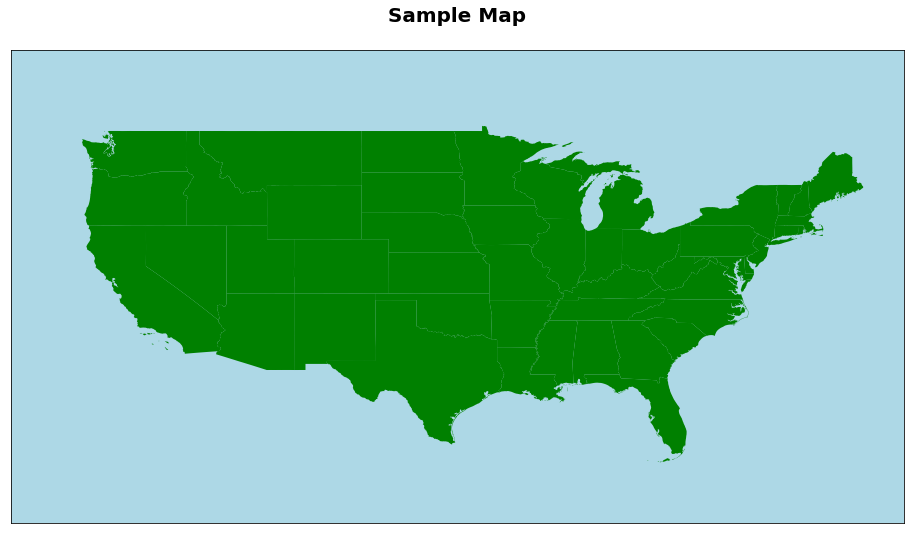

In [460]:
from matplotlib.colors import ListedColormap

sample = new_coord

# Set axis
fig,ax = plt.subplots(figsize=(16,10))
plt.ylim(20,55)
plt.xlim(-130, -64)

# Set Color map
cmap = ListedColormap(['green'], name='white')
ax = street_map.plot(ax=ax, cmap=cmap)
ax.set_facecolor('lightblue')

ax.set_xticks([])
ax.set_yticks([])

# set tour stop and connecting line
tour_stop = Point((new_coord))
gdf_am = gpd.GeoSeries([tour_stop])

#line = LineString([(sample),(-110,45)])
#gdf_ln = gpd.GeoSeries(line)

# Plot tour stop and line
#gdf_ln.plot(ax=ax, color='yellow', linewidth=3)
gdf_am.plot(ax=ax, markersize=10, color='yellow')

plt.title('Sample Map\n', fontsize=20, weight='bold')
# ann = ax.annotate('sample\ntext', ha='center', xy=sample, textcoords='offset points', fontsize=14, 
#     color = 'black', backgroundcolor='lightgrey', arrowprops=dict(arrowstyle="->",
#                     connectionstyle="arc3"))

#ann.set_bbox(dict(facecolor='white', alpha=1, edgecolor='red'))

#ann.set_alpha(.4)
#ann.set_bbox(dict(facecolor='white', alpha=0.2, edgecolor='red'))

#ann.remove()

;

### Create a Tour Route!

<b>Potential Tour Route Stops</b>

In [428]:
chicago = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'CHICAGO'].iloc[10][['latitude', 'longitude']])
losangeles = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'LOS ANGELES'].iloc[10][['latitude', 'longitude']])
bangor = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'BANGOR'].iloc[10][['latitude', 'longitude']])
philadelphia = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'PHILADELPHIA'].iloc[10][['latitude', 'longitude']])
seattle = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'SEATTLE-TACOMA'].iloc[10][['latitude', 'longitude']])
cleveland = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'CLEVELAND-AKRON'].iloc[10][['latitude', 'longitude']])
tampa = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'TAMPA-ST PETERSBURG-SARASOTA'].iloc[10][['latitude', 'longitude']])
wilkes_barre = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'WILKES BARRE-SCRANTON'].iloc[10][['latitude', 'longitude']])
altoona =  tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'JOHNSTOWN-ALTOONA'].iloc[10][['latitude', 'longitude']])
buffalo =  tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'BUFFALO'].iloc[10][['latitude', 'longitude']])
harrisburg = tuple(zip_code_DMA[zip_code_DMA.DMA_name == 'HARRISBURG-LANCASTER-LEBANON-YORK'].iloc[10][['latitude', 'longitude']])

<b>The tour mapping process, for visualization purposes, is outlined below:</b>
<br>

<ol>
    <li>
        Set the initial dimensions of a map figure, and create lists to ensure that the route does not re-visit itself.
    </li>
    <li>
        Iterate through 100 cities - find the closest DMA and coordinate set, and set the label for the map
    </li>
    <li>
        Plot a labeled point, and a connecting line between the previous point
    </li>
    <li>
        "Blur out" the previous stop name for clarity
     

((44.7001, -122.074), 29563    PORTLAND, OR
Name: DMA_name, dtype: object, 29563    OR
Name: state_x, dtype: object, array(['PORTLAND, OR, OR'], dtype=object), 25876)

((39.9465, -123.7552), 3365    SAN FRANCISCO-OAKLAND-SAN JOSE
Name: DMA_name, dtype: object, 3365    CA
Name: state_x, dtype: object, array(['SAN FRANCISCO-OAKLAND-SAN JOSE, CA'], dtype=object), 25527)

((39.3176, -122.5393), 2405    SACRAMENTO-STOCKTON-MODESTO
Name: DMA_name, dtype: object, 2405    CA
Name: state_x, dtype: object, array(['SACRAMENTO-STOCKTON-MODESTO, CA'], dtype=object), 25066)

((37.2001, -121.0047), 3376    FRESNO-VISALIA
Name: DMA_name, dtype: object, 3376    CA
Name: state_x, dtype: object, array(['FRESNO-VISALIA, CA'], dtype=object), 24651)

((37.5014, -118.4048), 2658    LOS ANGELES
Name: DMA_name, dtype: object, 2658    CA
Name: state_x, dtype: object, array(['LOS ANGELES, CA'], dtype=object), 24460)

((38.8688, -117.9221), 24872    LAS VEGAS
Name: DMA_name, dtype: object, 24872    NV
Name: state

((40.1326, -87.3819), 12006    INDIANAPOLIS
Name: DMA_name, dtype: object, 12006    IN
Name: state_x, dtype: object, array(['INDIANAPOLIS, IN'], dtype=object), 13230)

((38.2069, -87.9166), 12466    EVANSVILLE
Name: DMA_name, dtype: object, 12466    IN
Name: state_x, dtype: object, array(['EVANSVILLE, IN'], dtype=object), 12889)

((35.4452, -89.9236), 33626    MEMPHIS
Name: DMA_name, dtype: object, 33626    TN
Name: state_x, dtype: object, array(['MEMPHIS, TN'], dtype=object), 12791)

((32.9013, -91.0286), 20418    JACKSON, MS
Name: DMA_name, dtype: object, 20418    MS
Name: state_x, dtype: object, array(['JACKSON, MS, MS'], dtype=object), 12655)

((30.0276, -90.8605), 14988    NEW ORLEANS
Name: DMA_name, dtype: object, 14988    LA
Name: state_x, dtype: object, array(['NEW ORLEANS, LA'], dtype=object), 12494)

((31.2584, -88.3865), 1060    MOBILE-PENSACOLA
Name: DMA_name, dtype: object, 1060    AL
Name: state_x, dtype: object, array(['MOBILE-PENSACOLA, AL'], dtype=object), 12282)

((33

ValueError: min() arg is an empty sequence

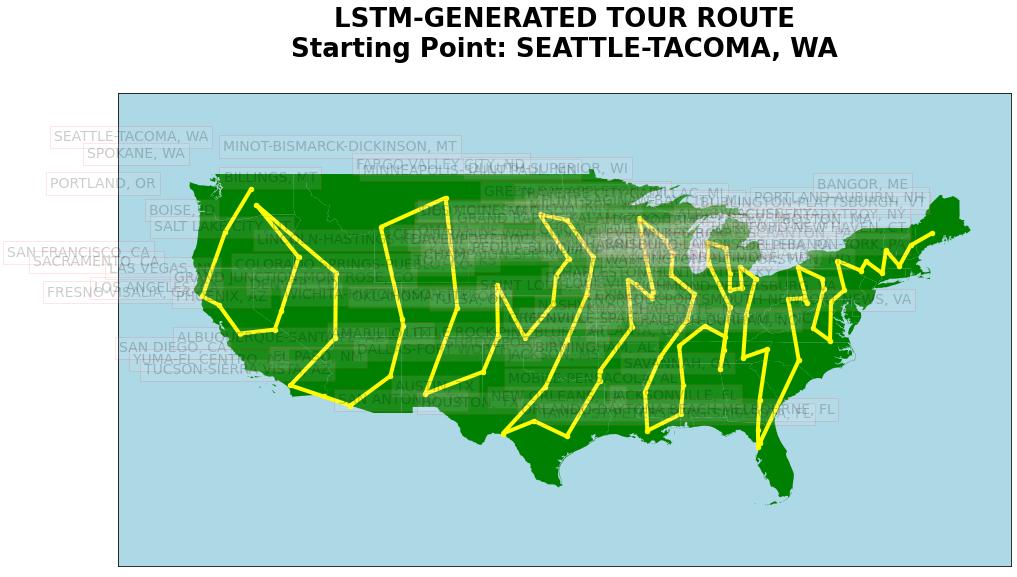

In [441]:
# Set Dimensions of Map Figure

fig,ax = plt.subplots(figsize=(16,16))
plt.ylim(20,55)
plt.xlim(-130, -64)

# Set Color Map and plot US map
cmap = ListedColormap(['green'], name='white')
ax = street_map.plot(ax=ax, cmap=cmap)
ax.set_facecolor('lightblue')

# Set Plot title and eliminate ticks
plt.title('LSTM-GENERATED TOUR ROUTE\nDecember 5, 2020', weight='bold', fontsize=24)
ax.set_xticks([])
ax.set_yticks([])

# Create list variables to avoid repeat stops
tour_list= []
visited_stops = []
visited_coords = []

# Set starting point
first_town = seattle


for i in range(0,100):
    
    if i == 0:
        town = first_town
    else:
        town = next_town
     
    # finds closest DMA to starting point - 'new' holds coordinates, city, state, and the full location tag
    new = find_closest_DMA(town)
    new_coord = new[0]
    new_city = new[1]
    new_state = new[2].values[0]
    array_details = new[3]
    
    
    # creates list of visited stops, not to be repeated
    visited_stops.append(new[1].values[0])
    visited_coords.append(new_coord)
    
    # as a correction on some city labels that have a state in their name, this code relabels if it is not a 
    # full cit yname with state
    if new_city.values[0][-4] == ',':
        label_name = new[1].values[0]
    else:
        label_name = str(new_city.values[0]) + ', ' +str(new_state)
        
        
    # text replacement for long metro names 
    if label_name == 'SAN FRANCISCO-OAKLAND-SAN JOSE, CA':
        label_name = 'SAN FRANCISCO, CA'
    elif label_name == 'SACRAMENTO-STOCKTON-MODESTO, CA':
        label_name = 'SACRAMENTO, CA'

    # plots new physical point on the map, and set it to a variable for plotting
    tour_stop = Point((new_coord[::-1]))
    gdf_am = gpd.GeoSeries([tour_stop])
    
    # set title of visual
    if i == 0:
        plt.title(f'LSTM-GENERATED TOUR ROUTE\nStarting Point: {label_name}\n', weight='bold', fontsize=26)
    
    # plot new tour stop
    gdf_am.plot(ax=ax, markersize=20, color='yellow')
    # annotate tour stop with the city label
    ann = ax.annotate(label_name, xy=tuple(town[::-1]), ha='center', textcoords='offset points', fontsize=20, backgroundcolor='w', 
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    ann.set_bbox(dict(facecolor='white', alpha=1, edgecolor='red'))

    # create a line from one point to the next, as long as it's not the first city
    if i != 0:
        line = LineString([tour_stop,visited_coords[i-1][::-1]])
        gdf_am = gpd.GeoSeries([tour_stop])
        gdf_ln = gpd.GeoSeries(line)
        gdf_am.plot(ax=ax, markersize=15, color='yellow')
        gdf_ln.plot(ax=ax, color='yellow', linewidth=4)


    # transforms coordinates to array
    transformed_coord = np.array([([new_coord])])

    # predicts latitude and longitude of new point
    new_lat = lat_model.predict(np.array(transformed_coord))[0][0]
    new_long = long_model.predict(np.array(transformed_coord))[0][0]

    # compiles latitude and longitude into one point and finds closest DMA of new predicted coordinates
    new_coords = np.array([np.float64(new_lat), np.float64(new_long)])

    # end the tour route visualization 
    if i != len(most_visited_cities)-1:
        next_town = find_closest_DMA(new_coords)

        print(str(next_town) + '\n')
        tour_list.append(next_town)
        next_town = np.array(next_town[0])
    
    # set this as a new visual four tour mapping animation
    plt.savefig(f'visualizations/tour_map_test_new_algo/stop{i}')

    # 'blur out' previous label
    ann.remove()
    ann = ax.annotate(label_name, xy=tuple(town[::-1]), textcoords='offset points', ha='center',
                      fontsize=14, backgroundcolor='w')
    ann.set_alpha(.2)
    ann.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='red'))
        

In [436]:
len(most_visited_cities)

96

In [461]:
lat_model.save('models/lat_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: models/lat_model/assets


INFO:tensorflow:Assets written to: models/lat_model/assets


In [462]:
long_model.save('models/long_model')

INFO:tensorflow:Assets written to: models/long_model/assets


INFO:tensorflow:Assets written to: models/long_model/assets


In [559]:
# Set Dimensions of Map Figure


def route_tour(first_town, stop_number):
    
    def find_closest_DMA(coordinates):  
        # filter to all results that have NOT been visited already
        zip_details = zip_code_DMA[~zip_code_DMA.DMA_name.isin(visited_stops)]['coordinates']
        zip_details = zip_details[zip_code_DMA.DMA_name.isin(most_visited_cities)]
        # zip_details = zip_details[~zip_code_DMA.state_x.isin(visited_states)]

        # finds closest location to known zip code / coordinate pairs 
        closest_coordinate = closest(zip_details, coordinates)
        coord_table = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate]


        # Establishes Geopy connectino for reverse lookup of coordinates
        from geopy.geocoders import Nominatim
        geolocator = Nominatim(user_agent="nickwilders")

        # set latitude and longitude for GeoPy to look up
        latitude, longitude = coordinates[0], coordinates[1]
        location = geolocator.reverse(str(latitude)+', '+str(longitude))

        # Set desired output
        full_name = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].full_metro_name.values
        no_state = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].DMA_name
        state = zip_code_DMA[zip_code_DMA.coordinates == closest_coordinate].state_x

        return closest_coordinate, no_state, state, full_name, len(zip_details)
    
    fig,ax = plt.subplots(figsize=(16,16))
    plt.ylim(20,55)
    plt.xlim(-130, -64)

    # Set Color Map and plot US map
    cmap = ListedColormap(['green'], name='white')
    ax = street_map.plot(ax=ax, cmap=cmap)
    ax.set_facecolor('lightblue')

    # Set Plot title and eliminate ticks
    plt.title('LSTM-GENERATED TOUR ROUTE\nDecember 5, 2020', weight='bold', fontsize=24)
    ax.set_xticks([])
    ax.set_yticks([])

    # Create list variables to avoid repeat stops
    tour_list= []
    visited_stops = []
    visited_coords = []

    for i in range(0,stop_number):
        if i == 0:
            town = first_town
        else:
            town = next_town

        # finds closest DMA to starting point (last town visited)
        new = find_closest_DMA(town)
        new_coord = new[0]
        new_city = new[1]
        new_state = new[2].values[0]
        array_details = new[3]


        # creates list of visited stops, not to be repeated
        visited_stops.append(new_city.values[0])
        visited_coords.append(new_coord)

        try:
            if new_city.values[0][-4] == ',':
                label_name = new_coord[1].values[0]
            else:
                label_name = str(new_city.values[0]) + ', ' +str(new_state)

            if label_name == 'SAN FRANCISCO-OAKLAND-SAN JOSE, CA':
                label_name == 'SAN FRANCISCO, CA'
            if label_name == 'SACRAMENTO-STOCKTON-MODESTO, CA':
                label_name == 'SACRAMENTO, CA'

            # Plots new point
            tour_stop = Point((new_coord[::-1]))
            gdf_am = gpd.GeoSeries([tour_stop])
            gdf_am.plot(ax=ax, markersize=20, color='yellow')
            ann = ax.annotate(label_name, xy=tuple(town[::-1]), ha='center', textcoords='offset points', fontsize=20, backgroundcolor='w', 
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3"))
            ann.set_bbox(dict(facecolor='white', alpha=1, edgecolor='red'))


            if i != 0:
                line = LineString([tour_stop,visited_coords[i-1][::-1]])
                gdf_am = gpd.GeoSeries([tour_stop])
                gdf_ln = gpd.GeoSeries(line)
                gdf_am.plot(ax=ax, markersize=15, color='yellow')
                gdf_ln.plot(ax=ax, color='yellow', linewidth=4)


            # transforms coordiantes to array
            transformed_coord = np.array([([new_coord])])

            # predicts latitude and longitude of new point
            new_lat = lat_model.predict(np.array(transformed_coord))[0][0]
            new_long = long_model.predict(np.array(transformed_coord))[0][0]

            # compiles latitude and longitude into one point and finds closest DMA of new predicted coordinates
            new_coords = np.array([np.float64(new_lat), np.float64(new_long)])
            next_town = find_closest_DMA(new_coords)
            
            tour_list.append(next_town)
            next_town = np.array(next_town[0])

            if i == 0:
                plt.title(f'LSTM-GENERATED TOUR ROUTE\nStarting Point: {new_coord[1].values[0]}\n', weight='bold', fontsize=26)
            
            #plt.tight_layout()
            
            plt.savefig(f'visualizations/tour_map_test_harrisburg/stop{i}')

            ann.remove()

            ann = ax.annotate(label_name, xy=tuple(town[::-1]), textcoords='offset points', ha='center',
                              fontsize=14, backgroundcolor='w')
            ann.set_alpha(.2)
            ann.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='red'))

            #ax.annotate(new_coord[1].values[0], xy=tuple(town[::-1]), textcoords='offset points', fontsize=14, 
            #            backgroundcolor='lightgrey', color='white', arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

        except:
            ann.remove()
            ann = ax.annotate(label_name, xy=tuple(town[::-1]), textcoords='offset points', ha='center',
                              fontsize=14, backgroundcolor='w')
            ann.set_alpha(.2)
            ann.set_bbox(dict(facecolor='white', alpha=0.1, edgecolor='red'))            
        